# Tarea 2

#### Instrucciones:
- La tarea consta de una parte de preguntas y otra de desarrollo de código. Debe entregar todas las respuestas en formato notebook, y cuando la respuesta sea texto, debe hacer en celdas markdown con formato. 
- La entrega de la Tarea es el día **17 de Octubre, 23:59 hrs.**


## Nombre(s):
- Justine Haefele
- Joseph Dabre

## Bosón de Higgs

En esta tarea trabajaremos con datos simulados del bosón de Higgs (versión simplificada), del desafío de [Kaggle](https://www.kaggle.com/c/higgs-boson/overview). Los archivos son Higgs_features.csv y Higgs_labels.csv. Las etiquetas son 0 (no hay señal de Higgs) y 1 (señal de Higgs). Las features son similares a los vistos en el set que utilizamos en clases, tales como energía faltantes, energía, momentum, rapidez transversal y azimutal, etc. Puede encontrar más detalles [acá](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Note que el set de datos para esta tarea es una versión simplificada.

### Parte 1: Descripción de los datos

Cargue los datos dataframes o arreglos de `numpy`, uno para features y otro para etiquetas

- Identifique cúantes instancias y características hay en el set de datos
- Haga un gráfico de la distribución (histograma) de cada feature en el set de datos, en un sólo gráfico. Agregue una leyenda con las etiquetas (Feature 1, Feature 2....etc.) y fije la transparencia de los histogramas (parámetro alpha) en 0.5 para que se noten mejor. ¿Observa algo inusual en la distribución de alguna de las features? Comente en el impacto de esto para su modelo
- ¿Está balanceadas las etiquetas del set del datos? ¿ Por qué esto es un problema? ¿Qué métrica nos conviene usar?




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
features = pd.read_csv('Higgs_features.csv', header = None) 
labels = pd.read_csv('Higgs_labels.csv', header = None)

In [3]:
labels.shape

(25000, 1)

Le agregamos `header = None` ya que las columnas no tienen nombre. De esta manera se le ponen nombres numéricos: feature 1, feature 2, etc.

In [4]:
# Con shape podemos ver la cantidad de (filas, columnas) = (labels, features)
n_labels, n_features = features.shape
print(f"Número de etiquetas: {n_labels}")
print(f"Número de características: {n_features}")


Número de etiquetas: 25000
Número de características: 8


Revisando la estructura de los datos:

In [5]:
features.head(5)

,0,1,2,3,4,5,6,7
0,393.335,79.460,308.879,4.095,1.403,-1.411,49.063,39.478
1,71.048,29.291,55.602,2.439,1.667,-1.412,22.926,9.486
2,141.450,87.017,72.091,1.472,4.714,1.233,23.591,69.754
3,156.539,39.797,127.933,4.017,1.279,-1.408,21.415,18.222
4,89.639,34.399,66.741,2.934,1.417,-1.377,26.459,8.257


In [6]:
labels.head(7)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,1


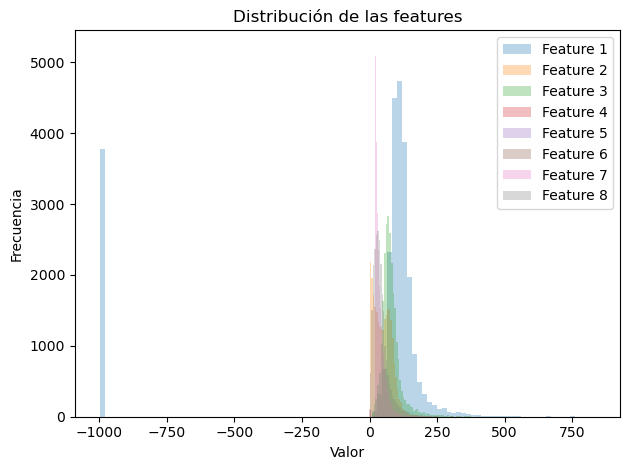

In [7]:
plt.figure()

for i in range(n_features):
    plt.hist(features[i], bins=100, alpha=0.3, label=f'Feature {i+1}')

plt.title("Distribución de las features")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Mostrar los valores más frecuentes de la feature 1 (columna 0)
valores_frecuentes = features[0].value_counts().sort_values(ascending=False)
print(valores_frecuentes.head(10))

0
-999.000    3783
 104.438       5
 122.959       4
 103.762       4
 96.913        4
 66.584        4
 83.845        4
 90.999        4
 104.049       4
 100.091       4
Name: count, dtype: int64


Podemos visualizar que la Feature 1 presenta un comportamiento anómalo puesto que hay un valor ($-999$) que se aleja bastante del rango normal del resto de los datos, y con una alta frecuencia ($3783$). Podría representar valores faltantes que fueron rellenados con valores muy poco probables, lo que no tendría un sentido físico. 

Si no tratamos esto,  el modelo puede aprender relaciones erróneas o dar peso indebido a este valor.

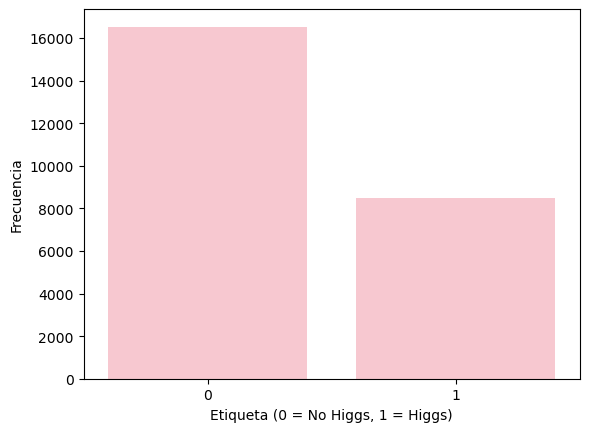

0
0    16526
1     8474
Name: count, dtype: int64


In [9]:
sns.countplot(x=labels[0], color = 'pink')
plt.xlabel("Etiqueta (0 = No Higgs, 1 = Higgs)")
plt.ylabel("Frecuencia")
plt.show()

conteo_etiquetas = labels[0].value_counts()
print(conteo_etiquetas)

Vemos que las clases se encuentran desbalanceadas ya que hay $16526$ etiquetas $0$ vs $8474$ etiquetas $1$. (casi el doble!)

Esto es un problema para nuestro modelo ya que puede favorecer demasiado a la clase mayoritaria, pero menospreciar la clase minoritaria, que usualmente es la que más nos importa (el $1$ en este caso representa la detección del Bosón de Higgs). Es por esto que en estos casos de clases desbalanceadas, no es bueno utilizar la métrica accuracy. Es mejor usar métricas que tengan en cuenta el desempeño en ambas clases, como lo hace la precision, recall, F1 score, la curva precison-recall o ROC y su respectiva área bajo la curva. 

### Parte 2: Árbol de decisión

- Implemente un clasificador de árbol de decisión con validación cruzada, para una métrica de su elección en base a lo respondido en la pregunta anterior. Reporte el promedio y desviación estándar de los scores obtenidos en los 5 folds.
- Para esta muestra en particular se recomienda usar `StratifiedKFold`. ¿Por qué?
- Genere las etiquetas predichas con `cross_val_predict` y genere la matriz de confusión
- A partir de la matriz de confusión indique los valores de TP, TN, FP, FN. ¿Qué error domina, FP o FN?

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree #modelo de árbol de decisión
from sklearn import metrics #métricas de evaluación
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

##### K-Fold Cross Validation

Se refiere al proceso de dividir el dataset en K partes, entrenando el modelo K veces, cada vez usando una parte diferente como test y el resto como training.

cross_val_score divide automáticamente los datos en entrenamiento y prueba, varias veces (K-Folds).

El objetivo de la validación cruzada es: Evaluar el modelo con diferentes particiones de los datos. Calcular métricas de rendimiento más fiables.

Para asegurar que los resultados del entrenamiento sean consistentes y reproducibles (es decir, que se obtenga el mismo árbol de decisión cada vez que se entrene con los mismos datos), es necesario fijar el parámetro random_state. Esto establece una semilla para el generador de números aleatorios utilizado por el algoritmo. 

- Implemente un clasificador de árbol de decisión con validación cruzada, para una métrica de su elección en base a lo respondido en la pregunta anterior. Reporte el promedio y desviación estándar de los scores obtenidos en los 5 folds.

In [11]:
features = pd.read_csv('Higgs_features.csv', header=None)
labels = pd.read_csv('Higgs_labels.csv', header=None).squeeze()  # Convertimos a Serie

# Creamos el clasificador
model = DecisionTreeClassifier(random_state=123, max_depth = 3)  # limitar profundidad para que sea legible

# Validación cruzada con distintas métricas
f1 = cross_val_score(model, features, labels, cv=5, scoring='f1')
precision = cross_val_score(model, features, labels, cv=5, scoring='precision')
recall = cross_val_score(model, features, labels, cv=5, scoring='recall')

# Entrenamos el modelo en todos los datos
model.fit(features, labels)

print("F1-score en cada fold:", f1)
print("Promedio F1-score:", f1.mean())
print("Desviación estándar F1:", f1.std())
print('-----------------------------------------------------------------------')
print("Precisión en cada fold:", precision)
print("Promedio precisión:", precision.mean())
print("Desviación estándar precisión:", precision.std())
print('-----------------------------------------------------------------------')
print("Recall en cada fold:", recall)
print("Promedio recall:", recall.mean())
print("Desviación estándar recall:", recall.std())

F1-score en cada fold: [0.68382568 0.69409985 0.68930593 0.69937606 0.65148206]
Promedio F1-score: 0.6836179158919485
Desviación estándar F1: 0.016871870431658633
-----------------------------------------------------------------------
Precisión en cada fold: [0.67768116 0.71242236 0.69614922 0.67340251 0.69139073]
Promedio precisión: 0.6902091956487586
Desviación estándar precisión: 0.013924947841549736
-----------------------------------------------------------------------
Recall en cada fold: [0.69008264 0.67669617 0.68259587 0.72743363 0.6159292 ]
Promedio recall: 0.6785475023769473
Desviación estándar recall: 0.03595491870953925


#### Visualizamos el árbol

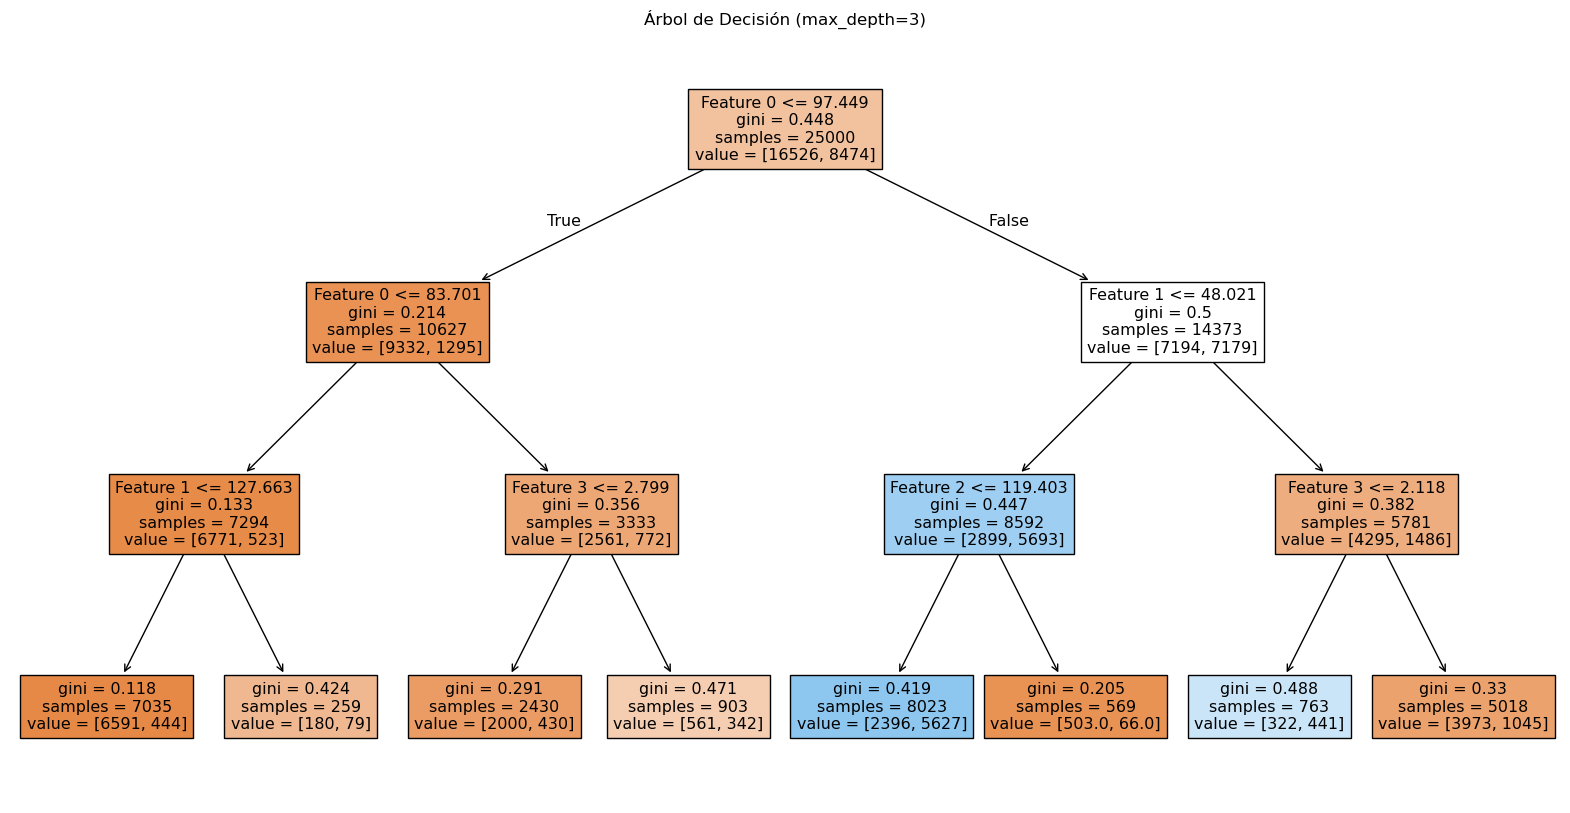

In [12]:
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=[f'Feature {i}' for i in range(features.shape[1])], filled=True)
plt.title("Árbol de Decisión (max_depth=3)")
plt.show()

- Para esta muestra en particular se recomienda usar `StratifiedKFold`. ¿Por qué?

En problemas de clasificación con clases desbalanceadas, un fold puede terminar con muy pocos o ningún ejemplo de una clase si se usa un KFold normal, el cual divide los datos aleatoriamente, sin respetar la distribución de las clases. Esto podría afectar negativamente a nuestro modelo de ML ya que algunos folds no serán representativos de los datos.

Si aplicamos este método a nuestros datos, se obtiene:

In [13]:
model = DecisionTreeClassifier(random_state=123, max_depth=3)

# Configuramos StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123) #Shuffle: that data should be randomly reordered

# Validación cruzada con StratifiedKFold y distintas métricas
f1 = cross_val_score(model, features, labels, cv=skf, scoring='f1')
precision = cross_val_score(model, features, labels, cv=skf, scoring='precision')
recall = cross_val_score(model, features, labels, cv=skf, scoring='recall')

# Entrenamos el modelo con los datos 
model.fit(features, labels)

print("F1-score en cada fold:", f1)
print("Promedio F1-score:", f1.mean())
print("Desviación estándar F1:", f1.std())
print('-----------------------------------------------------------------------')
print("Precisión en cada fold:", precision)
print("Promedio precisión:", precision.mean())
print("Desviación estándar precisión:", precision.std())
print('-----------------------------------------------------------------------')
print("Recall en cada fold:", recall)
print("Promedio recall:", recall.mean())
print("Desviación estándar recall:", recall.std())

F1-score en cada fold: [0.66708941 0.7089403  0.70601719 0.66745492 0.69509476]
Promedio F1-score: 0.688919317399939
Desviación estándar F1: 0.01826788654874901
-----------------------------------------------------------------------
Precisión en cada fold: [0.72054795 0.68715393 0.68635097 0.66883886 0.65874274]
Promedio precisión: 0.684326890086463
Desviación estándar precisión: 0.021064101368519324
-----------------------------------------------------------------------
Recall en cada fold: [0.62101535 0.73215339 0.72684366 0.6660767  0.73569322]
Promedio recall: 0.6963564619879985
Desviación estándar recall: 0.045500367311714515


Con esto, cada K-fold tendrá app la misma proporción de clases que el conjunto original, haciendo la validación más representiva de los datos! Como podemos ver, las métricas obtenidas en este caso se parecen más entre sí, en comparación al modelo que generamos sin StratifiedKFold.

En cuanto a lo obtenido, podemos decir que:

F1-score promedio: 0.689
Indica un buen equilibrio entre precisión y recall, es decir, el modelo logra detectar correctamente casos positivos sin cometer tantos errores.

Precisión promedio: 0.684
De las veces que el modelo predice que hay una señal de Higgs, acierta en aproximadamente el 68% de los casos.

Recall promedio: 0.696
El modelo detecta correctamente casi el 70% de las señales reales de Higgs. 

Se obtuvieron desviaciones estándar semejantes, lo que sugiere que el modelo es estable entre distintos folds de la validación cruzada.

- Genere las etiquetas predichas con cross_val_predict y genere la matriz de confusión

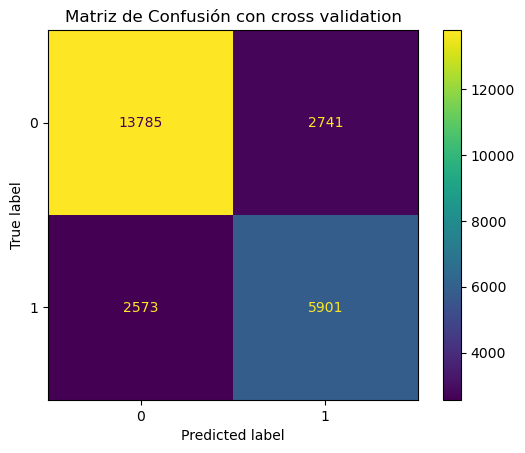

In [14]:
# predicciones con validación cruzada
predicted_labels = cross_val_predict(model, features, labels, cv=skf)

m_confusion = confusion_matrix(labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix= m_confusion)
disp.plot()
plt.title("Matriz de Confusión con cross validation")
plt.show()

- A partir de la matriz de confusión indique los valores de TP, TN, FP, FN. ¿Qué error domina, FP o FN?

En este caso, recordemos que las etiquetas son 0 (no hay señal de Higgs) y 1 (señal de Higgs). Por lo tanto, de analizar la matriz de confusión se tiene que hay:

5901 TP (True Positives): Hay señal de Higgs (1) y el modelo predijo correctamente (1).

13785 TN (True Negatives): No hay señal (0) y el modelo predijo correctamente (0).

2741 FP (False Positives): No hay señal (0), pero el modelo predijo que sí hay señal (1).

2573 FN (False Negatives): Hay señal de Higgs (1), pero el modelo predijo que no (0).

De esta forma, vemos que domina el error de los False Positives (FP), es decir, lo casos en que NO hay señal de Higgs, pero el moelo predijo que SÍ había. Sin embargo, no hay mucha diferencia entre los FP y los FN.

### Parte 3: SVMs

- Ahora usemos un clasificador usando SVM. Usando SVC, deje los parámetros del clasificador los que viene por defecto y haga una validación cruzada con k=5 y reporte los scores, como hizo antes con el árbol de decisión. ¿Qué algoritmo tiene mejor performance?
Nota: SVMs es un algoritmo lento y puede tomar tiempo este cálculo. Si toma demasiado tiempo, reduzca el número de folds (no menos de 3).
- Reporte la matriz de confusión para SVC. Hay algún cambio de los valores de FP y FN respecto al modelo de árbol de decisión?

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [16]:
# Creamos el clasificador SVM con los parámetros por defecto
svm_model = SVC()

# StratifiedKFold con k=5 o 3
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Validación cruzada con distintas métricas
f1 = cross_val_score(svm_model, features, labels, cv=skf, scoring='f1')
precision = cross_val_score(svm_model, features, labels, cv=skf, scoring='precision')
recall = cross_val_score(svm_model, features, labels, cv=skf, scoring='recall')

print("SVM - F1-score en cada fold:", f1)
print("Promedio F1-score:", f1.mean())
print("Desviación estándar F1:", f1.std())
print('-----------------------------------------------------')
print("SVM - Precisión en cada fold:", precision)
print("Promedio precisión:", precision.mean())
print("Desviación estándar precisión:", precision.std())
print('-----------------------------------------------------')
print("SVM - Recall en cada fold:", recall)
print("Promedio recall:", recall.mean())
print("Desviación estándar recall:", recall.std())

SVM - F1-score en cada fold: [0.6633224  0.66231021 0.65407593]
Promedio F1-score: 0.6599028452188488
Desviación estándar F1: 0.004140921109374221
-----------------------------------------------------
SVM - Precisión en cada fold: [0.72900763 0.72425389 0.7178511 ]
Promedio precisión: 0.7237042072022987
Desviación estándar precisión: 0.004571190454539554
-----------------------------------------------------
SVM - Recall en cada fold: [0.60849558 0.61012748 0.60070796]
Promedio recall: 0.60644367285885
Desviación estándar recall: 0.0041101126661311615


Analizando las métricas obtenidas, podemos ver que el modelo tiene:

Alta precisión (72%): pocos falsos positivos (cuando predice señal de Higgs, suele tener razón).

Recall (60%): deja pasar algunas señales reales de Higgs sin detectarlas.

F1-score (66%): equilibrado

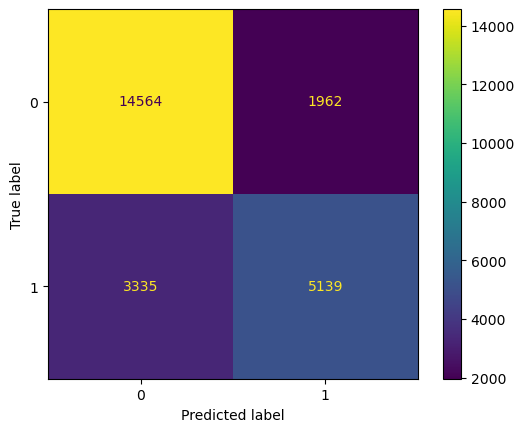

In [17]:
# predicciones 
svm_preds = cross_val_predict(svm_model, features, labels, cv=skf)

m_confusion = confusion_matrix(labels, svm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix= m_confusion)
disp.plot()

TP (True Positives) = 5139

TN (True Negatives) = 14564

FP (False Positives) = 1962

FN (False Negatives) = 3335

Al comparar las matrices de confusión de SVC y el arbol de decisión, podemos ver que el modelo SVC presenta menos falsos positivos (FP) ($1962$ SVC vs $2741$ DT), lo que significa que tiene una mejor precisión. Sin embargo, SVC tiene una mayor cantidad de falsos negativos (FN) ($3335$ SVC vs $2573$ DT), lo que significa que no detecta más señales reales de Higgs, lo cual se traduce en un peor recall.


### Parte 4: optimización de hiperparámetros

- Intente optimizar los parámetros de SVC. Para evitar que tome demasiado tiempo, seleccione solo el primer 5% de los datos (asegúrese de desordenarlos antes)
- Haga un esquema de CV con GridSearch, con los siguientes valores de parámetros:
parameters = {'kernel':['linear','rbf'],'C':[1, 10, 100], 'gamma':[0.01, 0.1, 0.5], 'class_weight':[{1:1},{1:3},{1:5}]}
- Recuerde seguir usando la métrica que eligió más arriba.
- Esto tomará tiempo! Fije verbose=2 en GridSearch para monitorear el progreso, y njobs=4 o más para acelerar un poco el proceso.
- Reporte los parámetros y scores del mejor modelo



In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [19]:
piped_model = make_pipeline(StandardScaler(), SVC()) 

piped_model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'transform_input': None,
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [20]:
from sklearn.model_selection import cross_validate, GridSearchCV

# Separamos un 5% de los datos
X_sub, _, y_sub, _ = train_test_split(features, labels, train_size=0.05, stratify=labels, random_state=42)

# Parámetros proporcionados
parameters = {'svc__kernel':['linear', 'rbf'],
              'svc__gamma':[0.01, 0.1, 0.5 ], 'svc__C':[1.0, 10.0, 100.0],
              'svc__class_weight':[{1:1},{1:3},{1:5}]}

# CV para todos los valores de los parámetros del GridSearch
optimized_model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1', \
                     verbose = 2, n_jobs = 4, return_train_score=True)

# Hacemos validación cruzada para el Gridsearch
scores = cross_validate(optimized_model, X_sub, y_sub, cv=skf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, n_jobs=4, return_estimator=True)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1.0, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1.0, sv

In [21]:
print("SVM - F1-score en cada fold:", scores['test_f1'])
print("Promedio F1-score:", scores['test_f1'].mean())
print("Desviación estándar F1:", scores['test_f1'].std())
print('-----------------------------------------------------')
print("SVM - Precisión en cada fold:", scores['test_precision'])
print("Promedio precisión:", scores['test_precision'].mean())
print("Desviación estándar precisión:", scores['test_precision'].std())
print('-----------------------------------------------------')
print("SVM - Recall en cada fold:", scores['test_recall'])
print("Promedio recall:", scores['test_recall'].mean())
print("Desviación estándar recall:", scores['test_recall'].std())

SVM - F1-score en cada fold: [0.69148936 0.69724771 0.66428571]
Promedio F1-score: 0.6843409274699535
Desviación estándar F1: 0.014374707310115557
-----------------------------------------------------
SVM - Precisión en cada fold: [0.55555556 0.61290323 0.66906475]
Promedio precisión: 0.6125078431878154
Desviación estándar precisión: 0.04634077721504317
-----------------------------------------------------
SVM - Recall en cada fold: [0.91549296 0.80851064 0.65957447]
Promedio recall: 0.7945260213764858
Desviación estándar recall: 0.10494520942049701


In [22]:
print('Mejores parámetros por Fold')
for i, est in enumerate(scores['estimator']):
    print(f'Fold {i+1}: {est.best_params_}')

Mejores parámetros por Fold
Fold 1: {'svc__C': 10.0, 'svc__class_weight': {1: 3}, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Fold 2: {'svc__C': 1.0, 'svc__class_weight': {1: 3}, 'svc__gamma': 0.5, 'svc__kernel': 'rbf'}
Fold 3: {'svc__C': 10.0, 'svc__class_weight': {1: 1}, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [23]:
maxf1 = int(np.argmax(scores['test_f1']))
best = scores['estimator'][maxf1]
print(best.best_params_)       

{'svc__C': 1.0, 'svc__class_weight': {1: 3}, 'svc__gamma': 0.5, 'svc__kernel': 'rbf'}


Los mejores parámetros son del Fold 2 para un F1-score = 0.697, siendo {'svc__C': 1.0, 'svc__class_weight': {1: 3}, 'svc__gamma': 0.5, 'svc__kernel': 'rbf'}

In [24]:
param_limpios = {k.replace('svc__',''): v for k, v in best.best_params_.items()}
param_limpios

{'C': 1.0, 'class_weight': {1: 3}, 'gamma': 0.5, 'kernel': 'rbf'}

¿Por qué se usó CV anidada?
Anteriormente optimizamos sin cv anidada y teníamos un recall altísimo que bajaba el f1-score. Según la documentación de Scki-kit learn, escoger los parámetros que maximizan el cv sin anidar, añaden bias al modelo respecto al data-set, lo que puede generar un score sobre-optimista.

### Parte 5: clases imbalanceadas
- Existen muchas estrategias para manejar clases imbalanceadas... (De hecho, en el paso anterior aplicamos una, puede decir cuál es?). Investigue o piense una solución para el desbalance, impleméntela para SVC con los parámetros optimizados, y comente su resultado, compare con el anterior

En el paso anterior aplicamos una función peso por clase para poder manejar las clases imbalanceadas. Viene de forma nativa en support vector machines, y re-escala el parámetro C para que el clasificador ponga enfásis en predecir correctamente esos puntos. Aunque el efecto de este parámetro es normalmente sutil. 

Utilizando SMOTE (Synthetic Minority Oversampling Technique), generamos datos sintéticos para balancear las clases y ver si tenemos mejora.

In [25]:
# Importamos SMOTE y Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

/home/justine/anaconda3/lib/python3.13/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [26]:
# Para evitar data leakage, trabajamos con el SMOTE antes de SVC en el pipeline
# Creamos el pipeline
smoted_now = Pipeline([('smote', SMOTE(random_state=42)),
                   ('scaler', StandardScaler()),
                   ('clf',SVC())])
# Parametros para el GridSearch, orbitando alrededor de los mejores parámetros obtenidos anteriormente
param_smotednow = {'smote__sampling_strategy':[0.5,1.0],
                'clf__kernel':['rbf'], 
                'clf__C':[1, 10, 100],
                'clf__gamma': [0.01, 0.1, 0.5],
                'clf__class_weight':[None]}
# Gridsearch
smotednow_grid = GridSearchCV(smoted_now, param_smotednow, cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1',
                            n_jobs=4, verbose=2)

# Extraemos los score
scores_smotednow = cross_validate(smotednow_grid, X_sub, y_sub, cv=skf, scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}, n_jobs=4, return_estimator=True)

/home/justine/anaconda3/lib/python3.13/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/justine/anaconda3/lib/python3.13/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threa


[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=linear; total time=   1.8s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=linear; total time=   2.3s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=linear; total time=   1.2s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.1, svc__kernel=linear; total time=   1.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.1, svc__

/home/justine/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/justine/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/justine/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/justine/anaconda3/lib/python3.13/site-packages/imblearn/pipeline.py", line 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=None, clf__gamma=0.0

/home/justine/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/justine/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/justine/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/justine/anaconda3/lib/python3.13/site-packages/imblearn/pipeline.py", line 

In [27]:
print("SVM - F1-score en cada fold:", scores_smotednow['test_f1'])
print("Promedio F1-score:", scores_smotednow['test_f1'].mean())
print("Desviación estándar F1:", scores_smotednow['test_f1'].std())
print('-----------------------------------------------------')
print("SVM - Precisión en cada fold:", scores_smotednow['test_precision'])
print("Promedio precisión:", scores_smotednow['test_precision'].mean())
print("Desviación estándar precisión:", scores_smotednow['test_precision'].std())
print('-----------------------------------------------------')
print("SVM - Recall en cada fold:", scores_smotednow['test_recall'])
print("Promedio recall:", scores_smotednow['test_recall'].mean())
print("Desviación estándar recall:", scores_smotednow['test_recall'].std())

SVM - F1-score en cada fold: [0.70553936 0.73684211 0.67069486]
Promedio F1-score: 0.7043587759706931
Desviación estándar F1: 0.027017398241286152
-----------------------------------------------------
SVM - Precisión en cada fold: [0.60199005 0.65384615 0.58421053]
Promedio precisión: 0.6133489099710624
Desviación estándar precisión: 0.02954147293221223
-----------------------------------------------------
SVM - Recall en cada fold: [0.85211268 0.84397163 0.78723404]
Promedio recall: 0.8277727832717344
Desviación estándar recall: 0.028857249546680272


In [28]:
# Obtengo los mejores parámetros en función del F1 más alto
maxf1_smotednow = int(np.argmax(scores_smotednow['test_f1']))
best_smotednow = scores_smotednow['estimator'][maxf1_smotednow] 
print(best_smotednow.best_params_)  

{'clf__C': 1, 'clf__class_weight': None, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'smote__sampling_strategy': 1.0}

[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=linear; total time=   1.6s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=linear; total time=   0.8s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=0.1, svc__kernel=linear; total time=   0.8s
[CV] END svc__C=100.0, svc__class_weight={1: 5}, svc__gamma=

Exception ignored in: <function ResourceTracker.__del__ at 0x726cf49928e0>
Traceback (most recent call last):
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.5, clf__kernel=rbf, smote__sampling_strategy=0.5; total tim

Exception ignored in: <function ResourceTracker.__del__ at 0x7d11b37968e0>
Traceback (most recent call last):
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5

Exception ignored in: <function ResourceTracker.__del__ at 0x7f21ca58e8e0>
Traceback (most recent call last):
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.01, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.1, clf__kernel=rbf, smote__sampling_strategy=1.0; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=0.5, clf__kernel=rbf, smote__sampling_strategy=0.5; total tim

Exception ignored in: <function ResourceTracker.__del__ at 0x7a9d0ed8e8e0>
Traceback (most recent call last):
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/justine/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Los scores para los mejores parámetros: 
* F1-score = 0.73684211
* Precision = 0.65384615
* Recall = 0.84397163


#### Nota:
Estuve bastante tiempo intentando entender porque no tenía sentido utilizar SMOTE y fijar un class_weight, y caí en cuenta de que al balancear las clases, la relación es 1:1, por lo que si utilizo los parámetros obtenidos de la sección 4, voy a perder rendimiento.

### Parte 6: Conclusiones

- En base a sus resultados, cuál algoritmo de clasificación recomendaría para este problema?
- ¿Qué otras consideraciones o limitaciones tenemos?

Considerando los scores para el mejor Fold:
1. Árbol de decisión (con skf)
* f1-score = 0.7089403
2. SVM (sin tunning)
* f1-score = 0.6633224
3. SVM (tuneado)
* f1-score = 0.69724771
4. SVM (tuneado manejando el imbalance)
* f1-score = 0.73684211

El f1-score del SVM tuneado manejando el imbalance con SMOTE muestra el mejor desempeño, frente a los otros modelos. Por lo que recomendamos usar SVM con hiperparámetros optimizados y balanceo de clases, en este caso, balanceando clases con SMOTE.

Por otro lado, notamos que el SVM blanceado muestra que el tratamiento de desbalance de clases es necesario para mejorar la generalización y equidad de clasificación, aunque trabajar con el SVM balanceado incurre en un mayor gasto computacional.
Considerando que el tiempo de ejecución con un 5% de los datos no es increíblemente demandante, utilizar el 95% restante podría tomar hasta 19 veces más tiempo. 

El árbol de decisión por su lado, presenta resultados considerablemente competitivos frente a todo el trabajo necesario para levantar la performance del SVM, además de que es más fácil interpretar un árbol de decisión, lo que sería favorable en un entorno que valore la explicabilidad. 

Cabe destacar que al promediar los folds:


1. Árbol de decisión (con skf)
* f1-score = 0.69
* precision = 0.68
* recall = 0.69
2. SVM (sin tunning)
* f1-score = 0.66
* precision = 0.72
* recall = 0.61
3. SVM (tuneado)
* f1-score = 0.68
* precision = 0.61
* recall = 0.79
4. SVM (tuneado manejando el imbalance)
* f1-score = 0.70
* precision = 0.61
* recall = 0.83

Lo que mantiene la conclusión anterior.

Por otro lado, podríamos realizar un análisis más robusto incluyendo otras métricas y otros clasificadores como RandomForest, XGBoost, entre otros, para comparar un rendimiento general.

Por último, al intentar predecir la detección del Bosón de Higgs, la métrica que más nos importa es el Recall, que en definitiva destaca en el SVM tuneado, considerando que la precision general no es tan baja a pesar de haber introducido datos sintéticos con SMOTE. 